In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

import keras
import tensorflow as tf

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
label_list = [i for i in range(10)]

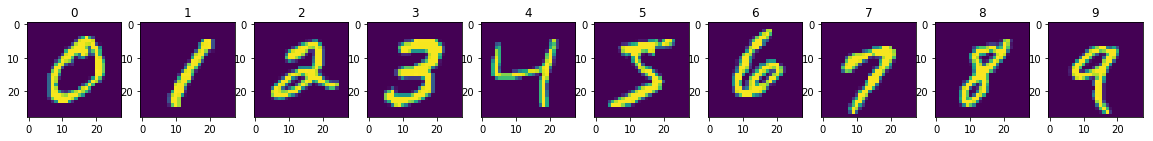

In [3]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord]])

plt.show()

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

In [7]:
model = keras.models.load_model('../../models/mnist_gradcam.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




## Saliency

![Screenshot from 2019-11-15 12-56-30](https://user-images.githubusercontent.com/33189954/68916005-95a87700-07a7-11ea-9800-00fcedab36d1.png)

In [43]:
idx = 3

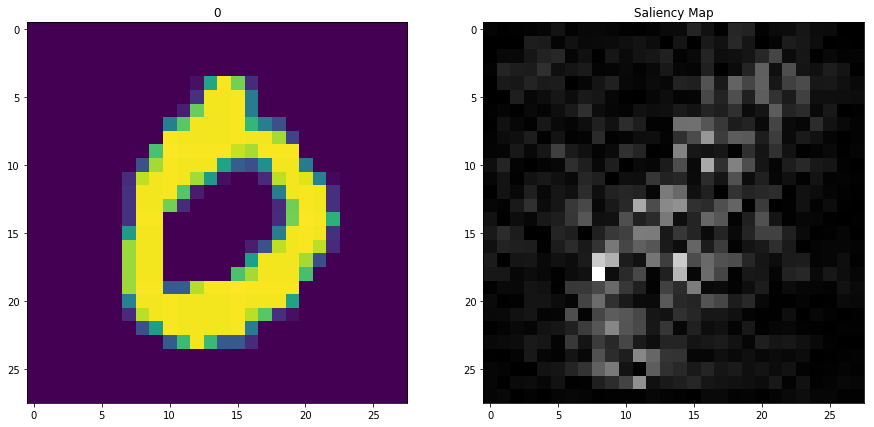

In [75]:
def get_saliency(idx, model):
    y_c = model.output[0, idx]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    return saliency([x_train[idx][np.newaxis,...,np.newaxis]/255])

grads_orig = get_saliency(idx, model)
s_map = np.abs(grads_orig[0][0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(122)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.show()

# SmoothGrad
![Screenshot from 2019-11-15 12-59-28](https://user-images.githubusercontent.com/33189954/68916071-d0121400-07a7-11ea-9c3b-379e40782747.png)

In [76]:
def get_smoothgrad(idx,model,n = 10, sigma = 1):
    y_c = model.output[0,idx]
    grad = keras.backend.gradients(y_c,model.input)[0]
    saliency = keras.backend.function([model.input],[grad])
    img_input = x_train[idx][np.newaxis,...,np.newaxis]/255
    result = np.zeros_like(img_input)
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma,size=img_input.shape)])[0]
        return result / n

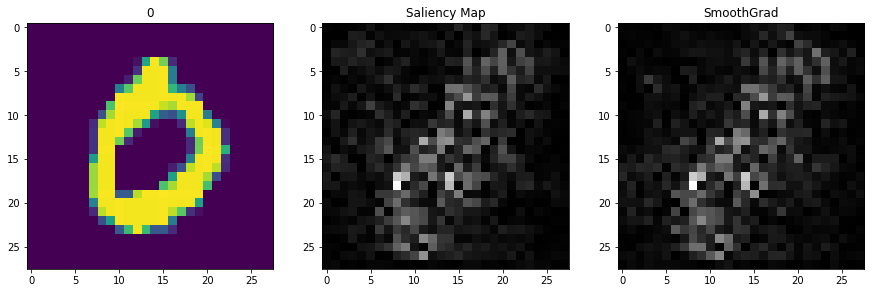

In [77]:
n = 100
sigma = 0.0001

grads_output = get_smoothgrad(idx, model, n, sigma)
sgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(132)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(133)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.show()

# vargrad

![Screenshot from 2019-11-15 13-27-12](https://user-images.githubusercontent.com/33189954/68917001-b377db00-07ab-11ea-8cc3-21d670b1cad7.png)

In [78]:
def get_vargrad(idx, model, n=10, sigma=1):
    y_c = model.output[0, idx]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    img_input = x_train[idx][np.newaxis,...,np.newaxis]/255
    
    smoothgrad = np.zeros_like(img_input)
    result = np.zeros_like(img_input)
    for i in range(n):
        smoothgrad += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    smoothgrad /= n
    
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]**2 - smoothgrad**2
    
    return result / n

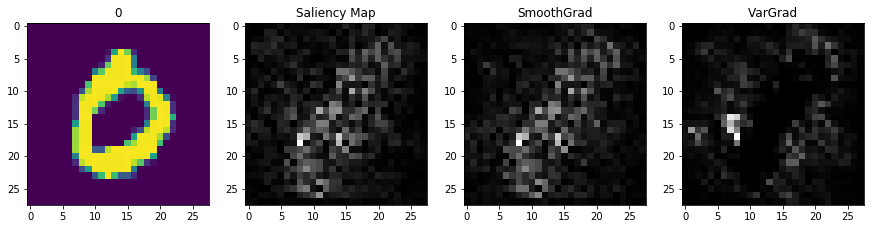

In [79]:

n = 10
sigma = .0001

grads_output = get_vargrad(idx, model, n, sigma)

vgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

# Integrated gradients
![Screenshot from 2019-11-15 13-28-51](https://user-images.githubusercontent.com/33189954/68917039-e15d1f80-07ab-11ea-893b-237b7af6fa58.png)


In [80]:
def get_integratedgrad(idx, model,step= 50, baseline=None):
    y_c = model.output[0,idx]
    grad = keras.backend.gradients(y_c,model.input)[0]
    saliency = keras.backend.function([model.input],[grad])
    img_input = x_train[idx][np.newaxis,...,np.newaxis]/255
    
    if baseline is None:
        baseline = 0 * img_input
    assert baseline.shape == img_input.shape
    temp = np.zeros_like(img_input)

    inputs = [baseline + (float(j)/step * img_input-baseline) for j in range(step +1)]
    for inp in inputs:
        temp +=saliency([inp])[0]
    return (img_input-baseline) * temp / step

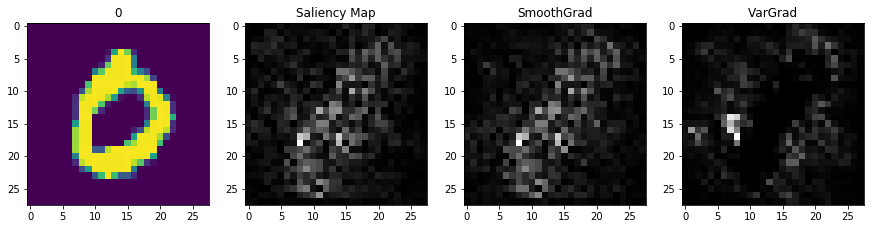

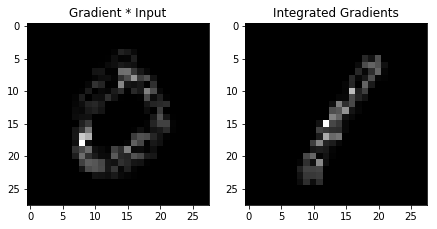

In [81]:
grads_output = get_integratedgrad(idx, model)
integratedgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(141)
plot5 = np.abs(x_test[idx]*np.squeeze(grads_orig[0]))
plt.imshow(plot5, 'gray')
plt.title('Gradient * Input')
plt.subplot(142)
plt.imshow(integratedgrad, 'gray')
plt.title('Integrated Gradients')
plt.show()

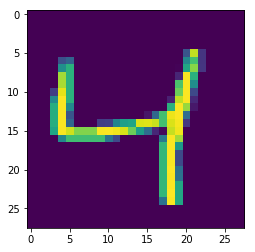

In [82]:
coord = np.where(y_train.flatten() == 4)[0][0]
plt.imshow(x_train[coord])

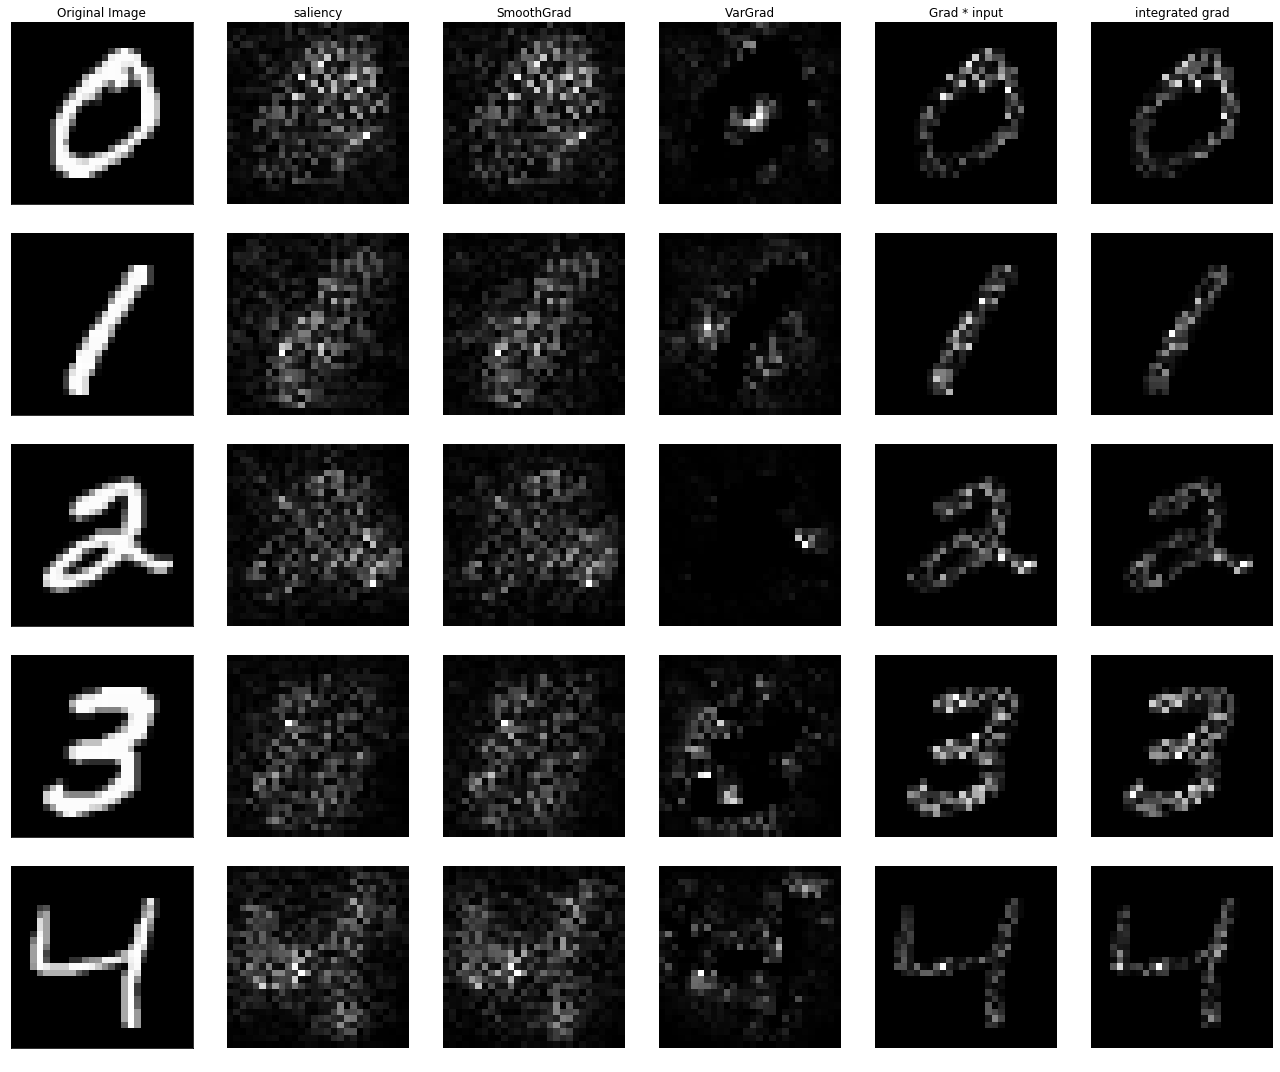

In [89]:
f, ax = plt.subplots(5, 6, figsize=(20, 15))

row = 5
col = 6
color = 'gray'

# coord = np.where(y_train.flatten() == i)[0][0]
# plt.imshow(x_train[coord])

results = []
for i in range(row):
    coord = np.where(y_train.flatten() == i)[0][0]
    target_image = x_train[coord]

    ax[i,0].imshow(target_image, color)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    # set title
    if i == 0:
        ax[i,0].set_title('Original Image')

    # saliency
    grads_orig = get_saliency(coord, model)
    s_map = np.abs(grads_orig[0][0].mean(axis=-1))
    # SmoothGrad
    grads_output = get_smoothgrad(coord, model, n, sigma)
    sgrad = np.abs(grads_output[0].mean(axis=-1))
    # VarGrad
    grads_output = get_vargrad(coord, model, n, sigma)
    vgrad = np.abs(grads_output[0].mean(axis=-1))
    # Grad * input
    grad_input = np.abs(x_train[coord]*np.squeeze(grads_orig[0]))
    # integrated grad
    grads_output = get_integratedgrad(coord, model)
    integratedgrad = np.abs(grads_output[0].mean(axis=-1))
    
    results.append([s_map, sgrad, vgrad, grad_input, integratedgrad])
    

names = ['saliency', 'SmoothGrad', 'VarGrad', 'Grad * input', 'integrated grad']
    
for i in range(row*(col-1)):
    r = i//(col-1)
    c = i%(col-1)
    ax[r,c+1].imshow(results[r][c], color)
    ax[r,c+1].axis('off')

    if r == 0:
        ax[r,c+1].set_title(names[c])
plt.subplots_adjust(wspace=-0.5, hspace=0)
plt.tight_layout()

# Cam coherence

In [6]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D , GlobalAveragePooling2D
from keras import backend as K

from vis.visualization import visualize_cam
import matplotlib.pyplot as plt
import numpy as np

from keras.models import *
from keras.callbacks import *
import keras.backend as K
#from model import *
#from data import *
import cv2
import argparse


Using TensorFlow backend.


In [7]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import tensorflow as tf

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [10]:
model = keras.models.load_model('../../input/XAI/models/mnist_cam.h5')

In [11]:
def generate_cam(tl_model, img, idx):
    
    ## img_path -> preprocessed image tensor
    #img_arr, img_tensor = preprocess_input(img)
    #img_tensor = np.asarray(img)[:,:,]
    
    img_tensor = img[np.newaxis,...,np.newaxis]/255.
    
    f_k = tl_model.get_layer('conv2d_19').output
    model_input = tl_model.input
    get_output = K.function([model_input],[f_k])
    
    [conv_outputs] = get_output([img_tensor])
    conv_outputs = conv_outputs[0]
    
    #print("conv_outputs->",conv_outputs.shape[0:2])
    
    class_weights = tl_model.layers[-1].get_weights()[0][:, idx]
    #print("class_weights .shape->",class_weights.shape)
    
    ## generate cam
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for k, w in enumerate(class_weights):
        #print(cam.shape, k, conv_outputs.shape)
        cam += w * conv_outputs[:, :, k]
        
    cam /= np.max(cam)
    cam = cv2.resize(cam, (28, 28))
    
    #heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    #heatmap[np.where(cam < 0.1)] = 0
    #img_heatmap = heatmap*0.5 + img
    
    img = cv2.resize(img, (28, 28))
    
    #print('grad-cam->', cam.shape,'img_shape->',img.shape)
    
    plt.imshow(cam, cmap="jet")
    plt.imshow(img, cmap="jet", alpha=.5)
    
    return cam,img   
#img_arr ,cam, predictions,img_heatmap = generate_cam(model,original_img,0)

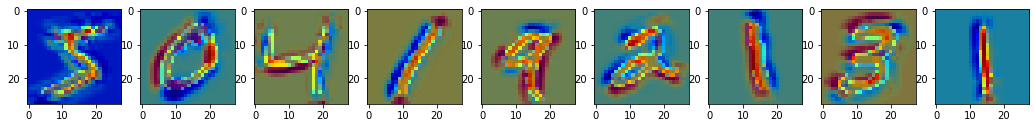

In [12]:
plt.figure(figsize=(20, 20))
for idx in range(9):
    plt.subplot(1,10,idx+1)
    #print(idx)
    coord = np.where(y_train.flatten() == idx)[0][0]
    #plt.imshow(x_train[coord])
    img,grad_cam=generate_cam(model,x_train[idx],idx)
    #plt.title(label_list[y_train[coord]])

#plt.show()

In [13]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import numpy as np
import argparse

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
    	self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():
	""" Class for making a forward pass, and getting:
	1. The network output.
	2. Activations from intermeddiate targetted layers.
	3. Gradients from intermeddiate targetted layers. """
	def __init__(self, model, target_layers):
		self.model = model
		self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

	def get_gradients(self):
		return self.feature_extractor.gradients

	def __call__(self, x):
		target_activations, output  = self.feature_extractor(x)
		output = output.view(output.size(0), -1)
		output = self.model.classifier(output)
		return target_activations, output

def preprocess_image(img):
	means=[0.485, 0.456, 0.406]
	stds=[0.229, 0.224, 0.225]

	preprocessed_img = img.copy()[: , :, ::-1]
	for i in range(3):
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
	preprocessed_img = \
		np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
	preprocessed_img = torch.from_numpy(preprocessed_img)
	preprocessed_img.unsqueeze_(0)
	input = Variable(preprocessed_img, requires_grad = True)
	return input

def show_cam_on_image(img, mask):
	heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
	heatmap = np.float32(heatmap) / 255
	cam = heatmap + np.float32(img)
	cam = cam / np.max(cam)
    #return cam
	cv2.imwrite("cam.jpg", np.uint8(255 * cam))

class GradCam:
	def __init__(self, model, target_layer_names, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()

		self.extractor = ModelOutputs(self.model, target_layer_names)

	def forward(self, input):
		return self.model(input) 

	def __call__(self, input, index = None):
		if self.cuda:
			features, output = self.extractor(input.cuda())
		else:
			features, output = self.extractor(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		self.model.features.zero_grad()
		self.model.classifier.zero_grad()
		one_hot.backward(retain_graph=True)

		grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

		target = features[-1]
		target = target.cpu().data.numpy()[0, :]

		weights = np.mean(grads_val, axis = (2, 3))[0, :]
		cam = np.zeros(target.shape[1 : ], dtype = np.float32)

		for i, w in enumerate(weights):
			cam += w * target[i, :, :]

		cam = np.maximum(cam, 0)
		cam = cv2.resize(cam, (224, 224))
		cam = cam - np.min(cam)
		cam = cam / np.max(cam)
		return cam

class GuidedBackpropReLU(Function):

    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input), torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output, positive_mask_1), positive_mask_2)

        return grad_input

class GuidedBackpropReLUModel:
	def __init__(self, model, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()

		# replace ReLU with GuidedBackpropReLU
		for idx, module in self.model.features._modules.items():
			if module.__class__.__name__ == 'ReLU':
				self.model.features._modules[idx] = GuidedBackpropReLU()

	def forward(self, input):
		return self.model(input)

	def __call__(self, input, index = None):
		if self.cuda:
			output = self.forward(input.cuda())
		else:
			output = self.forward(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		# self.model.features.zero_grad()
		# self.model.classifier.zero_grad()
		one_hot.backward(retain_graph=True)

		output = input.grad.cpu().data.numpy()
		output = output[0,:,:,:]

		return output

def get_args():
	parser = argparse.ArgumentParser()
	parser.add_argument('--use-cuda', action='store_true', default=False,
	                    help='Use NVIDIA GPU acceleration')
	parser.add_argument('--image-path', type=str, default='./examples/both.png',
	                    help='Input image path')
	args = parser.parse_args()
	args.use_cuda = args.use_cuda and torch.cuda.is_available()
	if args.use_cuda:
	    print("Using GPU for acceleration")
	else:
	    print("Using CPU for computation")

	return args

In [17]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [19]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

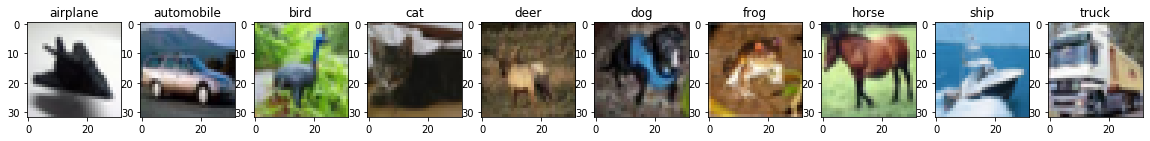

In [20]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])
plt.show()

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

In [24]:
target_index = None

In [26]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam
    #return cam
    #cv2.imwrite("cam.jpg", np.uint8(255 * cam))
    return cam

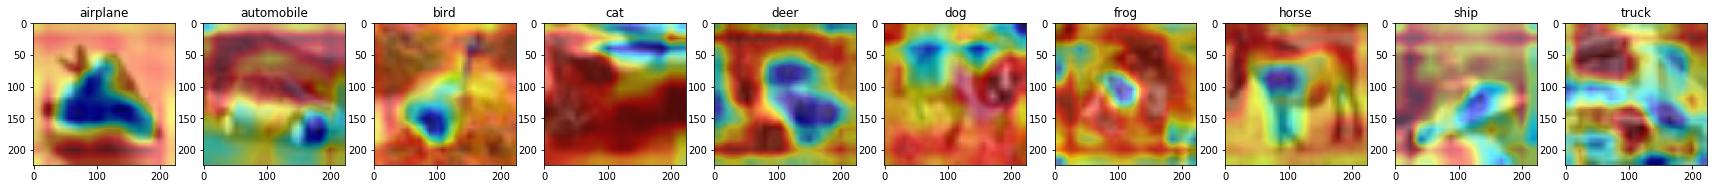

In [29]:
plt.figure(figsize=(30,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    img= np.float32(cv2.resize(x_train[coord],(224,224)))/255
    input = preprocess_image(img)
    
    grad_cam = GradCam(model = models.vgg19(pretrained=True), \
					target_layer_names = ["35"], use_cuda="use-cuda")
    mask = grad_cam(input,target_index)
    cam=show_cam_on_image(img,mask)
    plt.imshow(cam)
    plt.title(label_list[y_train[coord][0]])
    
    #plt.imshow(x_train[coord])
    #plt.title(label_list[y_train[coord][0]])

plt.show()

# perturbation 

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()

In [3]:
# parameter
learning_rate = 0.1
max_iterations = 1000
l1_coeff = 0.01
tv_coeff = 0.1
tv_beta = 3

# target image
#img_path = './dog_cat.jpg'
# img_path = ''

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dty

In [5]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
# total var
def total_var_norm(img, tv_beta):
    img = img[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1, :] - img[1:, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[:, :-1] - img[:, 1:])).pow(tv_beta))
    return row_grad + col_grad

In [7]:
# Imagenet Preprocess
def preprocess(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] -= means[i]
        preprocessed_img[:, :, i] /= stds[i]
        
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    img_tensor = Variable(preprocessed_img_tensor, requires_grad=False)
    return img_tensor

In [8]:
def numpy_to_torch(img, requires_grad=True):
    # mask
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        # image
        output = np.transpose(img, (2, 0, 1))
    output = torch.from_numpy(output)
    
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    img_tensor = Variable(output, requires_grad=requires_grad)
    return img_tensor

In [9]:
# load model
model = models.vgg19(pretrained=True)
model.eval()
if use_cuda:
    model.cuda()

# not train model
for p in model.features.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = False

In [73]:
# load img
#img = np.float32(cv2.resize(x_train[0],(224,224)))/255


# load img
original_img = cv2.imread("./images/dog_cat.jpg", 1)
#original_img = x_test[3]
#print(original_img)

original_img = cv2.resize(original_img, (224, 224))
img = np.float32(original_img) / 255
#print(original_img)


img= np.float32(cv2.resize(x_train[9],(224,224)))/255
original_img  = cv2.resize(x_train[9],(224,224))
#original_img = img

In [74]:
# blur img
blurred_img1 = cv2.GaussianBlur(img, (9, 9), 5)
blurred_img2 = np.float32(cv2.medianBlur(original_img, 9)) / 255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2

# mask
mask_init = np.ones((28, 28), dtype=np.float32)

In [75]:
# To torch tensor
img = preprocess(img)
blurred_img = preprocess(blurred_img2)
mask = numpy_to_torch(mask_init)

if use_cuda:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()
else:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))

In [76]:
# optimizer
optimizer = torch.optim.Adam([mask], lr=learning_rate)

target = torch.nn.Softmax()(model(img))

# inference target image category
category = np.argmax(target.cpu().data.numpy())

/home/jake/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [77]:
for i in tqdm(range(max_iterations)):
    
    # mask upsampling
    upsampled_mask = upsample(mask)

    # expand demension
    upsampled_mask = upsampled_mask.expand(1, 3, upsampled_mask.size(2), upsampled_mask.size(3))

    # masking
    perturbated_input = img.mul(upsampled_mask) + blurred_img.mul(1 - upsampled_mask)

    # make noise
    noise = np.zeros((224, 224, 3), dtype=np.float32)
    cv2.randn(noise, 0, 0.4)
    noise = numpy_to_torch(noise)
    
    # add noise
    perturbated_input = perturbated_input + noise
    
    # perturbated image output
    outputs = torch.nn.Softmax()(model(perturbated_input))
    
    # mask loss
    loss = l1_coeff * torch.mean(torch.abs(1 - mask)) + tv_coeff * total_var_norm(mask, tv_beta) + outputs[0, category]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # clamping
    mask.data.clamp_(0, 1)

100%|██████████| 1000/1000 [00:10<00:00, 92.01it/s]


In [78]:
# mask, img, blurred

tmp_m = upsampled_mask.cpu().data.numpy()[0]
tmp_m = np.transpose(tmp_m, (1, 2, 0))

tmp_m = (tmp_m - np.min(tmp_m)) / np.max(tmp_m)
tmp_m = 1 - tmp_m
heatmap = cv2.applyColorMap(np.uint8(255 * tmp_m), cv2.COLORMAP_JET)

heatmap = np.float32(heatmap) / 255
cam = heatmap + np.float32(original_img) / 255
cam /= np.max(cam)


In [79]:
np.shape(perturbated_input)

torch.Size([1, 3, 224, 224])

In [80]:
# mask, img, blurred

tmp_m = upsampled_mask.cpu().data.numpy()[0]
tmp_m = np.transpose(tmp_m, (1, 2, 0))

tmp_m = (tmp_m - np.min(tmp_m)) / np.max(tmp_m)
tmp_m = 1 - tmp_m
heatmap = cv2.applyColorMap(np.uint8(255 * tmp_m), cv2.COLORMAP_JET)

heatmap = np.float32(heatmap) / 255
cam = heatmap + np.float32(original_img) / 255
cam /= np.max(cam)


In [81]:
np.shape(heatmap)

(224, 224, 3)

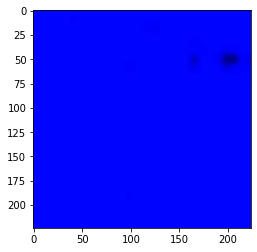

In [82]:
plt.imshow(heatmap)

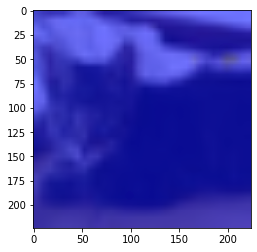

In [83]:
plt.imshow(cam)